# Infidelity Minimization with Stochastic Reconfiguration in NetKet

Authors: Luca Gravina and Alessandro Sinibaldi, August 2025

This tutorial demonstrates how to minimize the infidelity between a variational quantum state and a target state using NetKet.

- Fidelity between two states $|\psi\rangle$ and $|\phi\rangle$ is $F = |\langle \psi | \phi \rangle|^2/\langle \psi | \psi \rangle \langle \phi | \phi \rangle$. The infidelity is $1 - F$ and is minimized when the two states coincide up to a global phase.
- We will:
  1) Define a lattice, Hilbert space, variational model $|\psi(\theta)\rangle$, and Hamiltonian $H$.
  2) Construct a target state $| \psi_\mathrm{target} \rangle$ from exact diagonalization (ground state of $H$).
  3) Optimize the variational parameters by minimizing infidelity $1 - |\langle \psi(\theta) | \psi_\mathrm{target} \rangle|^2/ \langle \psi(\theta) | \psi(\theta) \rangle \langle \psi_\mathrm{target} | \psi_\mathrm{target} \rangle$ using the driver `nk.driver.Infidelity_SR` implementing infidelity minimization with Stochastic Reconfiguration (see [Sinibaldi et al.](https://quantum-journal.org/papers/q-2023-10-10-1131/) and [Gravina et al.](https://quantum-journal.org/papers/q-2025-07-22-1803/) for details).
  We consider also the case where we learn $O | \psi_\mathrm{target} \rangle$ for a given local operator $O$.
  4) Monitor convergence via the infidelity curve and validate energies against exact results.

## Setup and imports

We import the core NetKet library and experimental drivers, JAX/NumPy for array operations, and Matplotlib for plots.

In [ ]:
import netket as nk

print("Notebook run with NetKet version:", nk.__version__)

import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

## System, model definition and target state

We set up the physical problem:
- $L\times L$ square lattice of spins-$\tfrac{1}{2}$.
- Variational ansatz: Restricted Boltzmann Machine with real parameters.
- Transverse-field Ising Hamiltonian $H$.

In [ ]:
L = 4
g = nk.graph.Square(
    length=L,
)
hi = nk.hilbert.Spin(0.5, N=g.n_nodes)

ma = nk.models.RBM(alpha=3, param_dtype=jnp.float64)
n_samples = 2**13

H = nk.operator.Ising(hilbert=hi, graph=g, J=-1.0, h=3.04438)

## Target and variational states

- Compute the exact ground state $|\psi_\mathrm{target}\rangle$ via Lanczos ED.
- Build two MCState objects:
  - `vs_target`: LogStateVector initialized with exact amplitudes to represent $|\psi_\mathrm{target}\rangle$.
  - `vs`: RBM variational state $|\psi(\theta)\rangle$ to be optimized.

In [3]:
sa = nk.sampler.MetropolisLocal(hilbert=hi, n_chains_per_rank=16)
ma = nk.models.RBM(alpha=3, param_dtype=jnp.float64)

e_gs, v_gs = nk.exact.lanczos_ed(H, compute_eigenvectors=True)

vs_target = nk.vqs.MCState(
    sampler=sa,
    model=nk.models.LogStateVector(hi, param_dtype=jnp.float64),
    n_samples=n_samples,
    variables={"params": {"logstate": jnp.log(v_gs.astype(jnp.complex128)).squeeze()}},
)

vs = nk.vqs.MCState(
    sampler=sa,
    model=ma,
    n_samples=n_samples,
)

## Infidelity minimization (no operator)

We now minimize the infidelity $1 - |\langle \psi(\theta) | \psi_\mathrm{target} \rangle|^2 / \langle \psi(\theta) | \psi(\theta) \rangle \langle \psi_\mathrm{target} | \psi_\mathrm{target} \rangle$ using Stochastic Reconfiguration (SR):
- The SR metric preconditions parameter updates to approximate the natural gradient on the variational manifold.
- The regularization (diagonal shift) $\lambda_\mathrm{SR}$ stabilizes the metric inversion.

We run the driver for a fixed number of iterations and record the infidelity statistics.

In [ ]:
optimizer = nk.optimizer.Sgd(learning_rate=5e-2)
diag_shift = 1e-4

logger = nk.logging.RuntimeLog()
driver = nk.driver.Infidelity_SR(
    target_state=vs_target,
    optimizer=optimizer,
    diag_shift=diag_shift,
    variational_state=vs,
    operator=None,
)
driver.run(n_iter=100, out=logger)

### Monitoring convergence

We plot the infidelity versus iteration. A fast decay toward small values indicates $|\psi(\theta)\rangle$ matches $|\psi_\mathrm{target}\rangle$ up to a global phase.

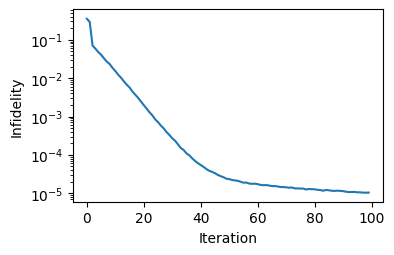

In [5]:
infidelity = logger["Infidelity"]["Mean"]
error = logger["Infidelity"]["Sigma"]

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.plot(range(len(infidelity)), infidelity, "-")
ax.fill_between(
    range(len(infidelity)), infidelity - error, infidelity + error, alpha=0.3
)
ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("Infidelity");

### Energy validation (ground state)

As a sanity check, we compute the energy of the learned variational state $E_\mathrm{VMC} = \langle \psi(\theta) | H | \psi(\theta) \rangle$ and compare it to the exact ground-state energy $E_0$ from ED. Agreement within tolerance confirms successful state learning.

In [6]:
psi = vs.to_array()
energy = psi.T @ H.to_sparse() @ psi

np.testing.assert_allclose(energy, e_gs, rtol=1e-5)

## Infidelity minimization with an operator

Sometimes we wish to match the state proportional to $O\,|\psi_\mathrm{target}\rangle$ for a physical operator $O$ (e.g., a transition operator). We define
- $O = \sum_i \sigma_i^+$
Then we repeat the optimization, now minimizing the infidelity to the normalized vector $\dfrac{O\,|\psi_\mathrm{target}\rangle}{\|O\,|\psi_\mathrm{target}\rangle\|}$.

In [ ]:
operator = sum([nk.operator.spin.sigmap(hi, i) for i in g.nodes()])

optimizer = nk.optimizer.Sgd(learning_rate=5e-2)
diag_shift = 1e-6

logger = nk.logging.RuntimeLog()
driver = nk.driver.Infidelity_SR(
    target_state=vs_target,
    optimizer=optimizer,
    diag_shift=diag_shift,
    variational_state=vs,
    operator=operator,
)
driver.run(n_iter=100, out=logger)

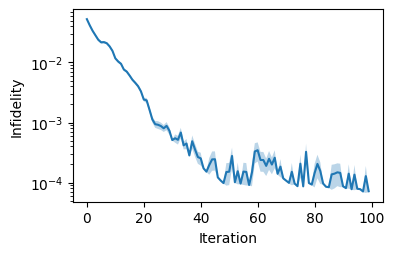

In [8]:
infidelity = logger["Infidelity"]["Mean"]
error = logger["Infidelity"]["Sigma"]

fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
ax.plot(range(len(infidelity)), infidelity, "-")
ax.fill_between(
    range(len(infidelity)), infidelity - error, infidelity + error, alpha=0.3
)
ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("Infidelity");

### Energy validation (operator-transformed target)

We construct the exact reference state $|\psi_\mathrm{ref}\rangle \propto O\,|\psi_\mathrm{target}\rangle$ and compare its energy $E_\mathrm{ref} = \langle \psi_\mathrm{ref} | H | \psi_\mathrm{ref} \rangle$ to that of the trained variational state $E_\mathrm{VMC} = \langle \psi(\theta) | H | \psi(\theta) \rangle$.

In [9]:
psi_target = operator.to_sparse() @ vs_target.to_array()
psi_target = psi_target / np.linalg.norm(psi_target)

energy_exact = psi_target.T @ H.to_sparse() @ psi_target

psi = vs.to_array()
energy_variational = psi.T @ H.to_sparse() @ psi

np.testing.assert_allclose(energy_variational, energy_exact, rtol=1e-3)